In [1]:
import altair as alt
import pandas as pd
from scipy.stats import ttest_ind

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

### Read the files into Pandas dataframes

In [2]:
clinicaldf = pd.read_excel('UCEC_clinical_genotype_phenotype_V1.1.tsi.xlsx', sheet_name="CPTAC3_UCEC_clinical_genotypes_")
clinicaldf.drop(clinicaldf.index[0], inplace=True)
clinicaldf.head()

,idx,Histologic_Grade_(FIGO),Histologic_Type,Num_full_term_pregnancies,Tumor_Size_(cm),FIGO_stage,Myometrial_invasion_Specify,Diabetes,BMI,LVSI,...,PI3K-PTEN,PI3K-PIK3R2,TP53-ATM,TP53-TP53,TP53-TP53_pathway,HRD-BRCA1,HRD-BRCA1_or_BRCA2,HRD-BRCA2,MSI,POLE
1,C3L-00006,1,0,1,2.9,0,1,0,38.88,1,...,1,0,0,1,1,0,0,0,1,0
2,C3L-00008,1,0,1,3.5,0,1,0,39.76,0,...,1,0,0,0,0,0,0,0,1,0
3,C3L-00032,2,0,4,4.5,0,1,1,51.19,0,...,0,0,0,0,0,0,0,0,0,0
4,C3L-00090,2,0,4,3.5,0,1,1,32.69,0,...,1,0,0,0,0,0,0,0,0,0
5,C3L-00098,3,0,2,6,0,1,0,20.28,NaN,...,0,0,0,1,1,0,0,0,0,0


In [3]:
phosdf = pd.read_excel('UCEC_phosphoproteomics_site_level_V1.xlsx', sheet_name="data")
phosdf.head()

,idx,C3L-00136.T,C3L-00098.T,C3L-00090.T,C3L-00008.T,C3L-00032.T,C3L-00006.T,C3L-00006.N,C3L-00139.T,C3L-00143.T,...,C3N-01349.T,C3N-03320.N,C3N-03411.N,NM_Mix1.N,C3N-03691a.N,C3N-03691b.N,C3N-03692.N,C3L-03601a.N,C3L-03601b.N,NM_Mix2.N
0,AAAS-S495,NaN,1.511548,1.112944,NaN,0.817520,NaN,NaN,1.418852,0.869111,...,0.987610,0.860698,0.567761,0.589163,0.655917,0.576749,0.945281,NaN,NaN,1.037036
1,AAK1-S18,0.879774,1.556005,NaN,0.692318,1.334778,0.821719,1.107258,1.336072,0.726407,...,1.004323,0.820971,0.930256,0.855603,1.676428,1.227982,1.139254,1.418611,1.994327,0.665400
2,AAK1-S20,0.696099,0.964754,0.687200,0.453538,0.966963,1.352040,0.905931,1.302045,0.880087,...,1.000152,1.166823,0.965710,0.966570,1.344240,1.650865,0.975370,0.928651,1.861469,0.550828
3,AAK1-S21,0.914304,0.949023,0.887574,1.068494,0.956485,1.434344,1.136394,1.239891,0.573554,...,0.598483,0.654774,NaN,0.553720,NaN,1.086362,0.659436,1.007299,1.331197,0.590478
4,AAK1-S624,2.024795,1.103993,1.153816,0.631918,0.977280,0.615934,0.759955,0.856731,1.114945,...,0.969571,1.067636,1.047008,0.831194,0.904264,1.051562,0.950879,0.718730,1.412013,0.764690


### Select the categorical variable (for now only 0/1 values) you would like to analyze as well as p-value cutoff

In [4]:
trait = 'Diabetes'
pCutoff = 0.05 / len(clinicaldf.index)
print(pCutoff)

0.0004950495049504951


### Create tables for analysis

In [5]:
traitdf = clinicaldf[['idx', trait]].dropna(axis=0).transpose()
traitdf.columns = traitdf.iloc[0]
traitdf = traitdf.iloc[1].to_frame().transpose()
traitdf.head()

idx,C3L-00006,C3L-00008,C3L-00032,C3L-00090,C3L-00098,C3L-00136,C3L-00137,C3L-00139,C3L-00143,C3L-00145,...,C3N-01212,C3N-01217,C3N-01219,C3N-01267,C3N-01510,C3N-01520,C3N-01521,C3N-01537,C3N-01802,C3N-01825
Diabetes,0,0,1,1,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,1,0


In [6]:
phosTumors = phosdf.filter(regex='(idx)|(\.T)')
phosTumors = phosTumors.rename(columns=lambda x: x.replace('.T', '')).set_index('idx')
singleClinical = pd.concat([phosTumors, traitdf], axis=0, sort=True)
singleClinical = singleClinical.transpose()
singleClinical.head()

,AAAS-S495,AAK1-S18,AAK1-S20,AAK1-S21,AAK1-S624,AAK1-S637,AAK1-S670,AAK1-S678,AAK1-S682,AAK1-S731,...,ZZEF1-S1488,ZZEF1-S1501,ZZEF1-S1518,ZZEF1-S2444,ZZEF1-T1477,ZZEF1-T1512,ZZEF1-T1521,ZZZ3-S397,ZZZ3-S426,Diabetes
C3L-00006,NaN,0.821719,1.35204,1.43434,0.615934,0.624679,0.713503,0.740894,0.523559,NaN,...,0.87033,0.926385,0.925015,0.948549,0.831736,NaN,1.17917,1.33593,0.833387,0
C3L-00008,NaN,0.692318,0.453538,1.06849,0.631918,0.748012,0.744204,0.818215,0.761952,0.840007,...,1.29373,1.51129,1.25731,NaN,2.1862,2.00179,1.26739,0.877979,0.684302,0
C3L-00032,0.81752,1.33478,0.966963,0.956485,0.97728,1.73528,NaN,0.376517,1.11497,0.939985,...,1.53038,NaN,1.28393,1.44461,1.42989,1.21832,0.827654,NaN,NaN,1
C3L-00090,1.11294,NaN,0.6872,0.887574,1.15382,0.88684,1.49998,1.41776,NaN,0.695361,...,0.884547,NaN,1.59942,1.21403,NaN,1.80377,0.803419,1.02033,0.595455,1
C3L-00098,1.51155,1.55601,0.964754,0.949023,1.10399,1.54743,1.43527,0.590696,0.810401,0.996133,...,1.39109,0.615914,1.19357,0.666592,0.632036,0.911677,0.862623,0.932446,1.10916,0


In [7]:
negTrait = singleClinical[singleClinical[trait] == 0]
posTrait = singleClinical[singleClinical[trait] == 1]

### Perform t-tests in a for loop and keep the significant results

In [9]:
locNames = list(posTrait)
sigList = list()
for i in range(0, len(list(singleClinical))):
    if (locNames[i] == trait):
        continue
    oneSiteNeg = negTrait[[trait, locNames[i]]]
    oneSitePos = posTrait[[trait, locNames[i]]]
    tResult = ttest_ind(oneSiteNeg[locNames[i]], oneSitePos[locNames[i]])
    if (tResult[1] <= pCutoff):
        sigList.append(locNames[i])
        print(locNames[i])
        print(tResult)

MIA3-S1741
Ttest_indResult(statistic=-3.7501672208837764, pvalue=0.00030216684092952494)
RPTOR-S863
Ttest_indResult(statistic=-3.6165305741713376, pvalue=0.0004782117374317231)
TSC2-S1452
Ttest_indResult(statistic=-3.7387199964016347, pvalue=0.0003144172212645126)


### Visualize

In [17]:
negMean = negTrait.mean(axis=0)[sigList[0]]
posMean = posTrait.mean(axis=0)[sigList[0]]
data = pd.DataFrame({trait: [('No ' + trait), trait],
                    sigList[0]: [negMean, posMean]})

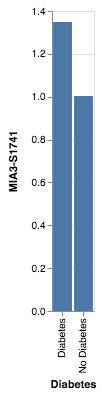

In [18]:
alt.Chart(data).mark_bar().encode(
    x = trait,
    y = sigList[0]
)

### A more meaningful visualization would be better, so look into that